In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import os, subprocess, gc, time, datetime
from itertools import product

import models.models_original as models_original
import models.models_3d_atomics as new_models
from vasopressor.preprocess_helpers import load_and_create_MIMIC_dataloader, load_MIMIC_data
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import *

gpu_id = int(subprocess.check_output('nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader | nl -v 0 | sort -nrk 2 | cut -f 1 | head -n 1 | xargs', shell=True, text=True))
device = torch.device(f'cuda:{gpu_id}') if torch.cuda.is_available else torch.device('cpu')
print("current device", device)

current device cuda:15


In [2]:
train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = 1)

print(class_weights, num_classes, seq_len)

for batch in train_loader:
    [print(t.shape, t.device) for t in batch]
    break

len(train_loader)

tensor([0.5797, 3.6376], dtype=torch.float64) 2 6
torch.Size([512, 6, 27]) cpu
torch.Size([512, 6, 27]) cpu
torch.Size([512, 8]) cpu
torch.Size([512, 2]) cpu


35

In [3]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.yscale("log")
    plt.legend()
    plt.show()

def plot_metrics(history, n_concepts_list):
    plt.plot(history[:, 0], history[:, 2], label=f'AUC')
    plt.plot(history[:, 0], history[:, 3], label=f'ACC')
    plt.plot(history[:, 0], history[:, 4], label=f'F1')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title('Plot of Concepts vs Criteria')
    plt.xticks(n_concepts_list)

    plt.legend()
    plt.show()

def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "auc", "acc", "f1"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["auc"], label='AUC')
    plt.plot(mean_atomics.index, mean_atomics["acc"], label='ACC')
    plt.plot(mean_atomics.index, mean_atomics["f1"], label='F1')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["auc"], label='AUC')
    plt.plot(mean_concepts.index, mean_concepts["acc"], label='ACC')
    plt.plot(mean_concepts.index, mean_concepts["f1"], label='F1')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()


In [4]:
def initializeModel(n_concepts, static_dim, changing_dim, seq_len, output_dim, use_indicators, use_only_last_timestep, use_fixes, top_k=''):
    model = models_original.CBM(static_dim = static_dim, 
                                changing_dim = changing_dim, 
                                seq_len = seq_len,
                                num_concepts = n_concepts,
                                use_indicators = use_indicators,
                                use_fixes = use_fixes,
                                use_only_last_timestep = use_only_last_timestep,
                                use_grad_norm = False,
                                noise_std = False,
                                use_multiplicative_interactions = False,
                                use_summaries = True,
                                opt_lr = 1e-3,
                                opt_weight_decay = 1e-5,
                                l1_lambda=1e-3,
                                cos_sim_lambda=1e-2,
                                output_dim = output_dim,
                                top_k=top_k,
                                device = device
                                )
    model = model.to(device)
    return model

def initializeModel_with_atomics(n_atomics, n_concepts, static_dim, changing_dim, seq_len, output_dim, use_summaries_for_atomics, use_indicators, use_fixes, top_k=''):
    model = new_models.CBM(static_dim = static_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            num_atomics= n_atomics,
                            use_summaries_for_atomics = use_summaries_for_atomics,
                            use_indicators = use_indicators,
                            use_fixes = use_fixes,
                            use_grad_norm = False,
                            noise_std = False,
                            use_summaries = True,
                            opt_lr = 1e-3,
                            opt_weight_decay = 1e-5,
                            l1_lambda=1e-3,
                            cos_sim_lambda=1e-2,
                            output_dim = output_dim,
                            top_k=top_k,
                            device = device
                            )
    model = model.to(device)
    return model


In [5]:
seq_len = seq_len
changing_dim = len(changing_vars)
static_dim = len(static_names)

print(changing_dim, static_dim, seq_len)

random_seed = 1
set_seed(random_seed)


27 8 6


## Optimization

In [6]:
# feature weights
config_original = {
    "n_concepts": 4,
    "use_indicators": True,
    "use_fixes": False,
    "use_only_last_timestep": True,
}

experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/original/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_original.keys()]) + "seed_{seed}.pt"

train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

top_k_file = "" # "/workdir/optimal-summaries-public/_models/vasopressor/original/top-k/bottleneck_topkinds.csv"

model_og = initializeModel(**config_original, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, top_k=top_k_file)
model_og.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config_original, seed = random_seed), max_epochs=10000)

evaluate_classification(model_og, test_loader, num_classes=num_classes, device=device)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_use_indicators_True_use_fixes_False_use_only_last_timestep_True_seed_1.pt
AUC macro 0.9116973876953125
ACC macro 0.8319889903068542
 F1 macro 0.8405277729034424


(0.9116973876953125, 0.8319889903068542, 0.8405277729034424)

## Optimization Atomics

In [7]:
# feature weights
config_atomics = {
    "n_atomics": 10, # 30
    "n_concepts": 4, # 20
    "use_indicators": True,
    "use_fixes": False,
    "use_summaries_for_atomics": True,
}

experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/atomics/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_atomics.keys()]) + "seed_{seed}.pt"

train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

model_atomic_sum2atom = initializeModel_with_atomics(**config_atomics, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2)
model_atomic_sum2atom.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config_atomics, seed = random_seed), max_epochs=10000)

evaluate_classification(model_atomic_sum2atom, test_loader, num_classes=num_classes, device=device)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/n_atomics_10_n_concepts_4_use_indicators_True_use_fixes_False_use_summaries_for_atomics_True_seed_1.pt
AUC macro 0.9138913750648499
ACC macro 0.8373948931694031
 F1 macro 0.8451417684555054


(0.9138913750648499, 0.8373948931694031, 0.8451417684555054)

In [8]:
# feature weights
config_atomics = {
    "n_atomics": 10, # 30
    "n_concepts": 4, # 20
    "use_indicators": True,
    "use_fixes": False,
    "use_summaries_for_atomics": False,
}

experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/atomics/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_atomics.keys()]) + "seed_{seed}.pt"

train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

model_atomic_sum2con = initializeModel_with_atomics(**config_atomics, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2)
model_atomic_sum2con.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config_atomics, seed = random_seed), max_epochs=10000)

evaluate_classification(model_atomic_sum2con, test_loader, num_classes=num_classes, device=device)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/n_atomics_10_n_concepts_4_use_indicators_True_use_fixes_False_use_summaries_for_atomics_False_seed_1.pt
AUC macro 0.9049535989761353
ACC macro 0.8470911383628845
 F1 macro 0.8527272939682007


(0.9049535989761353, 0.8470911383628845, 0.8527272939682007)

## NNI

In [9]:
import nni
from nni.algorithms.feature_engineering.gradient_selector import FeatureGradientSelector

In [27]:
X_time, X_ind, X_static, Y_logits, changing_vars, static_names = load_MIMIC_data()
print(X_time.shape)

X_time_2d = X_time.reshape(X_time.shape[0], -1) # result is V1_T1, V2_T1, V3_T1, ..., V1_T2, V2_T2, V3_T2, ... repeat V, T times

X_ind_2d = X_ind.reshape(X_ind.shape[0], -1)
X = np.concatenate((X_time_2d, X_ind_2d, X_static), axis=1).astype(np.float32)

y = Y_logits[:, 1] #.astype(np.float32)

print(X.shape, X.dtype, np.isnan(X).any(), type(X), y.shape, y.dtype, np.isnan(y).any(), type(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

fgs = FeatureGradientSelector(preprocess = None, verbose = 100)
fgs.fit(X_train, y_train)

print(fgs.get_selected_features())


(29137, 6, 27)
(29137, 332) float32 False <class 'numpy.ndarray'> (29137,) int64 False <class 'numpy.ndarray'>
Finding data statistics...

TypeError: type not understood

## Pruning

In [165]:
def get_evaluator(model):
    optimizer = nni.trace(torch.optim.Adam)(model.parameters(), lr=model.opt_lr, weight_decay=model.opt_weight_decay)

    def training_model(model, optimizer, training_step, lr_scheduler, max_steps, max_epochs, *args, **kwargs):
        # max_steps, max_epochs might be None, which means unlimited training time,
        # so here we need set a default termination condition (by default, total_epochs=10, total_steps=100000).
        total_epochs = max_epochs if max_epochs else 10
        total_steps = max_steps if max_steps else 100000
        current_step = 0

        # init dataloader
        train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader()

        for epoch in range(total_epochs):
            for batch in train_loader:
                optimizer.zero_grad()
                loss = training_step(batch, model, class_weights)
                loss.backward()
                optimizer.step()
                current_step += 1
                if current_step >= total_steps:
                    return

    def training_step(batch, model, class_weights, *args, **kwargs):
        *input_data, target = extract_to(batch, device)
        result = model(*input_data)
        return model.compute_loss(target, result, class_weights.to(device=device))

    from nni.compression import TorchEvaluator
    evaluator = TorchEvaluator(training_model, optimizer, training_step)
    return evaluator


In [180]:
def agp_prune(model, sparse_ratio):
    from nni.compression.pruning import L1NormPruner, LinearPruner, AGPPruner

    config_list = [{
        'op_types': ['Linear'],
        'exclude_op_names_re': ['.*layer_output.*'],
        'sparse_ratio': sparse_ratio,
        # 'granularity': 'in_channel' # default is "out_channel"
    }]
    
    subpruner = L1NormPruner(model, config_list, get_evaluator(model))
    pruner = AGPPruner(subpruner, interval_steps=100, total_times=10)

    # print(model)
    
    _, masks = pruner.compress(max_steps=100 * 10, max_epochs=None) # max_steps=100 * 10, max_epochs=None
    # show the masks sparsity
    for name, mask in masks.items():
        print(name, ' sparsity : ', '{:.2}'.format(mask['weight'].sum() / mask['weight'].numel()))
        
    # pruner.unwrap_model()
    return pruner, masks

def prune(model, sparse_ratio):
    from nni.compression.pruning import TaylorPruner, MovementPruner

    config_list = [{
        'op_types': ['Linear'],
        'exclude_op_names_re': ['.*layer_output.*'],
        'sparse_ratio': sparse_ratio,
        # 'granularity': 'in_channel' # default is "out_channel"
    }]
    
    # pruner = MovementPruner(model, config_list, get_evaluator(model), 0, 1500)
    pruner = TaylorPruner(model, config_list, get_evaluator(model), training_steps = 100)
    
    # print(model)
    
    _, masks = pruner.compress() # max_steps=2000, max_epochs=None
    # show the masks sparsity
    for name, mask in masks.items():
        print(name, ' sparsity : ', '{:.2}'.format(1 - mask['weight'].sum() / mask['weight'].numel()))  # 1 is unmasked, 0 is masked
        
    # pruner.unwrap_model()
    return pruner, masks
    

In [181]:
def plot_performance_over_sparsity(model):
    aucs, accs, f1s = [], [], []
    x = np.arange(0, 1.01, 0.05)
    for sparsity in x:
        pruner, masks = prune(model, sparsity)
        auc, acc, f1 = evaluate_classification(model, test_loader, num_classes=num_classes, device=device)
        aucs.append(auc)
        accs.append(acc)
        f1s.append(f1)
        pruner.unwrap_model()
    
    plt.plot(x, aucs, label="AUC")
    plt.plot(x, accs, label="ACC")
    plt.plot(x, f1s, label="F1")
    plt.legend()
    plt.ylabel("Performance")
    plt.xlabel("Sparsity Ratio")
    plt.show


In [182]:
pruner, masks = prune(model_og, 0.5)
auc, acc, f1 = evaluate_classification(model_og, test_loader, num_classes=num_classes, device=device)
print(auc, acc, f1)
pruner.unwrap_model()
masks

bottleneck  sparsity :  0.5
AUC macro 0.9049549698829651
ACC macro 0.8277844786643982
 F1 macro 0.8372922539710999
0.9049549698829651 0.8277844786643982 0.8372922539710999


defaultdict(dict,
            {'bottleneck': {'weight': tensor([[1., 1., 1.,  ..., 1., 1., 1.],
                      [0., 0., 0.,  ..., 0., 0., 0.],
                      [0., 0., 0.,  ..., 0., 0., 0.],
                      [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:11'),
              'bias': tensor([1., 0., 0., 1.], device='cuda:11')}})

bottleneck  sparsity :  0.0
AUC macro 0.9152235388755798
ACC macro 0.839625895023346
 F1 macro 0.8472415208816528
bottleneck  sparsity :  0.0
AUC macro 0.91556715965271
ACC macro 0.8400549292564392
 F1 macro 0.8473132252693176
bottleneck  sparsity :  0.0
AUC macro 0.9132052659988403
ACC macro 0.8373090624809265
 F1 macro 0.8449967503547668
bottleneck  sparsity :  0.0
AUC macro 0.9131797552108765
ACC macro 0.8367084264755249
 F1 macro 0.8447670936584473
bottleneck  sparsity :  0.0
AUC macro 0.9098972082138062
ACC macro 0.8337051868438721
 F1 macro 0.8419507145881653
bottleneck  sparsity :  0.0
AUC macro 0.9194067716598511
ACC macro 0.8477776050567627
 F1 macro 0.8544470071792603
bottleneck  sparsity :  0.0
AUC macro 0.9117257595062256
ACC macro 0.8361935615539551
 F1 macro 0.8443030714988708
bottleneck  sparsity :  0.0
AUC macro 0.9191005229949951
ACC macro 0.8464046716690063
 F1 macro 0.8531342148780823
bottleneck  sparsity :  0.0
AUC macro 0.9117034077644348
ACC macro 0.83627939224243

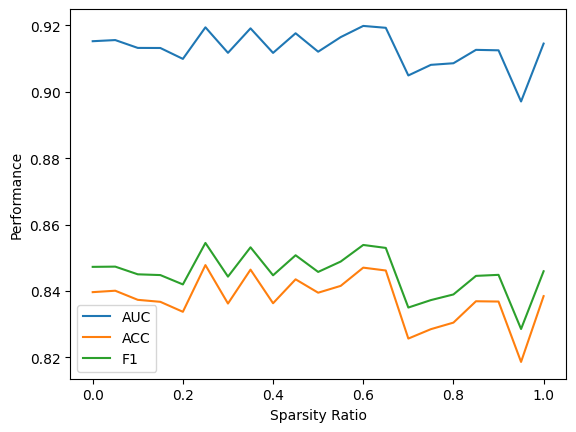

In [173]:
# masks = prune(model_og, 0.9)
# auc, acc, f1 = evaluate_classification(model_og, test_loader, num_classes=num_classes, device=device)

plot_performance_over_sparsity(model_og)

layer_time_to_atomics  sparsity :  0.0
layer_to_concepts  sparsity :  0.0
AUC macro 0.9067288637161255
ACC macro 0.830787718296051
 F1 macro 0.8409420847892761
layer_time_to_atomics  sparsity :  0.0
layer_to_concepts  sparsity :  0.0
AUC macro 0.9008771181106567
ACC macro 0.797236979007721
 F1 macro 0.8178524374961853
layer_time_to_atomics  sparsity :  0.0
layer_to_concepts  sparsity :  0.0
AUC macro 0.9086499810218811
ACC macro 0.8476059436798096
 F1 macro 0.8543784618377686
layer_time_to_atomics  sparsity :  0.0
layer_to_concepts  sparsity :  0.0
AUC macro 0.9064323306083679
ACC macro 0.8525828123092651
 F1 macro 0.8579460978507996
layer_time_to_atomics  sparsity :  0.1
layer_to_concepts  sparsity :  0.0
AUC macro 0.9059242606163025
ACC macro 0.8464046716690063
 F1 macro 0.8528686761856079
layer_time_to_atomics  sparsity :  0.1
layer_to_concepts  sparsity :  0.0
AUC macro 0.9034937620162964
ACC macro 0.841342031955719
 F1 macro 0.8498823046684265
layer_time_to_atomics  sparsity :  0.

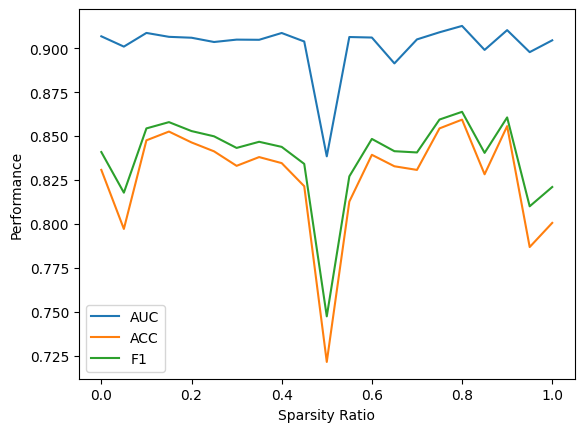

In [174]:
# masks = prune(model_atomic_sum2con, 0.9)
# evaluate_classification(model_atomic_sum2con, test_loader, num_classes=num_classes, device=device)
# masks

plot_performance_over_sparsity(model_atomic_sum2con)

layer_time_to_atomics  sparsity :  0.0
layer_to_concepts  sparsity :  0.0
AUC macro 0.9172564744949341
ACC macro 0.8456323742866516
 F1 macro 0.8521653413772583
layer_time_to_atomics  sparsity :  0.0
layer_to_concepts  sparsity :  0.0
AUC macro 0.9106023907661438
ACC macro 0.8343916535377502
 F1 macro 0.8425261378288269
layer_time_to_atomics  sparsity :  0.0
layer_to_concepts  sparsity :  0.0
AUC macro 0.9126530885696411
ACC macro 0.8373090624809265
 F1 macro 0.8449206352233887
layer_time_to_atomics  sparsity :  0.0
layer_to_concepts  sparsity :  0.0
AUC macro 0.9170519113540649
ACC macro 0.84425950050354
 F1 macro 0.851021945476532
layer_time_to_atomics  sparsity :  0.1
layer_to_concepts  sparsity :  0.0
AUC macro 0.9163376688957214
ACC macro 0.8428007364273071
 F1 macro 0.8497868180274963
layer_time_to_atomics  sparsity :  0.1
layer_to_concepts  sparsity :  0.0
AUC macro 0.919148325920105
ACC macro 0.8485498428344727
 F1 macro 0.8549116253852844
layer_time_to_atomics  sparsity :  0.1

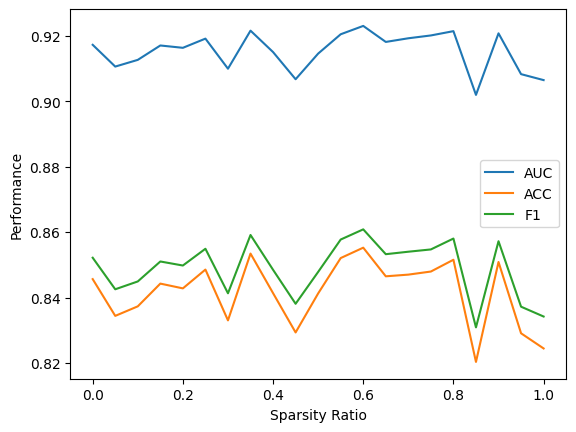

In [175]:
# masks = prune(model_atomic_sum2atom, 0.9)
# evaluate_classification(model_atomic_sum2atom, test_loader, num_classes=num_classes, device=device)
# masks

plot_performance_over_sparsity(model_atomic_sum2atom)